### Import des packages nécessaires

In [1]:
import sys
!"{sys.executable}" -m pip install tensorflow



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import et mise en forme des données

In [1]:
import xarray as xr

ds = xr.open_dataset("ERA5_2019-1_total_precipitation.nc", engine="netcdf4")
ds["tp"] = 1000*ds["tp"] # On passe en mètre

### Examen des données

In [2]:
print(ds)

<xarray.Dataset> Size: 6GB
Dimensions:    (longitude: 1440, latitude: 721, time: 744)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 6kB 2019-01-01 ... 2019-01-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float64 6GB 0.009077 0.009077 ... 0.0
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-10 09:37:02 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


 ### Tout lancer à partir d'ici si on souhaite éditer toutes les images (basse résolution, interpolation, kNN, ground truth)

### Exemple d'une visualisation de données à une heure donnée en Suisse avec une mauvais résolution (0.25°)

In [3]:
# Choisir le timestamp à analyser
cpc_file = "CPC_file/CPC1901804009_00060.801.h5"

ok


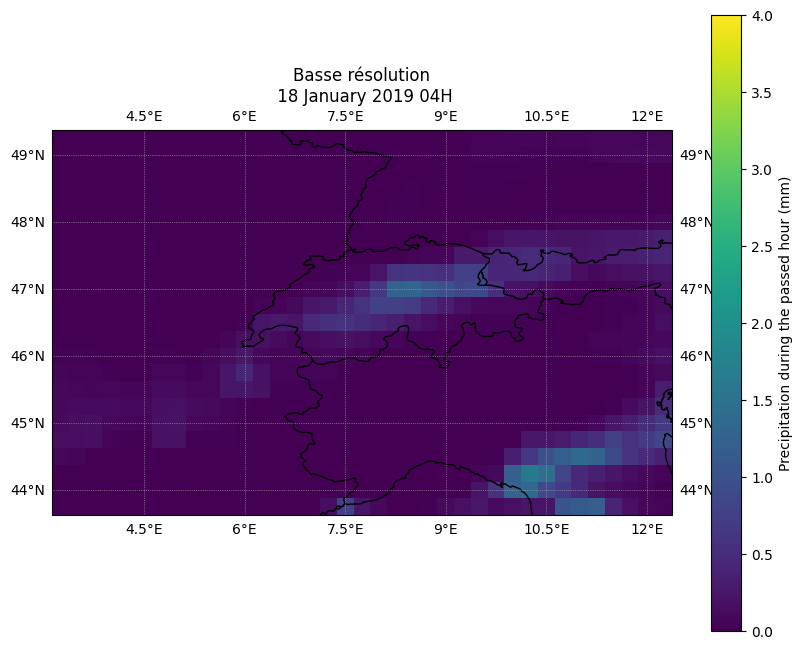

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# Attention, il faut mettre un jour de moins que ce que l'on vise, (24*4 donnera le 5/01), l'heure donne la plage [heure - 1, heure], comme CPC

ref_fichier = cpc_file[9:22]
date = f" {cpc_file[15:17]} January 2019 {cpc_file[17:19]}H"
échantillon_temps = 24*(int(ref_fichier[6:8]) - 1)+ int(ref_fichier[8:10])

vmin = 0
vmax = 4

# Chemin du dossier
chemin_image = os.path.join(os.getcwd(), "Images")
fichier = os.path.join(chemin_image, ref_fichier)

# Vérifier si le dossier existe

if not os.path.exists(fichier):
    print("ok")
    os.makedirs(fichier)  # Créer le dossier si il n'existe pas

def plot_map(df_plot, nom):
    # Créer une figure et un axe avec la projection PlateCarree
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})

    # Ajouter les côtes et les frontières
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')

    # Ajouter les frontières de la Suisse avec un fond
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

    # Définir l'étendue géographique pour zoomer sur la Suisse
    # ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())  # Longitude min, Longitude max, Latitude min, Latitude max

    # Tracer les précipitations sur la carte avec la palette conditionnée sur la Suisse
    df_plot.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', 
                        cbar_kwargs={'label': "Precipitation during the passed hour (mm)"}, 
                        vmin=vmin, vmax=vmax)

    # Ajouter une grille
    ax.gridlines(draw_labels=True, linestyle = ":", linewidth = .5)

    titre = nom.split("/")[-1][:-4] + "\n" + date
    ax.set_title(titre)

    # Afficher la carte
    plt.savefig(nom)
    plt.show()

# Extraire les latitudes et longitudes du Dataset ERA5
lats = ds['latitude']
lons = ds['longitude']

precip = ds.isel(time = échantillon_temps)

# Définir la zone de la Suisse en tenant compte des coordonnées 0-360 pour la longitude
lon_min_output = 3.168779677002355 
lat_min_output = 43.6290303456092 
lon_max_output = 12.46232838782734 
lat_max_output = 49.36326405028229

# Utiliser .where() pour filtrer les données dans cette région (filtrage flexible)
precip_suisse = precip.where(
    (precip['latitude'] >= lat_min_output) & (precip['latitude'] <= lat_max_output) &
    (precip['longitude'] >= lon_min_output) & (precip['longitude'] <= lon_max_output), drop=True
)

#precip_mean = ds["tp"].sum(dim="time")
plot_map(precip_suisse["tp"], f"Images/{ref_fichier}/Basse résolution.png")

## Implémentation de l'interpolation bicubique et visualisation du résultat (résolution = 1km)

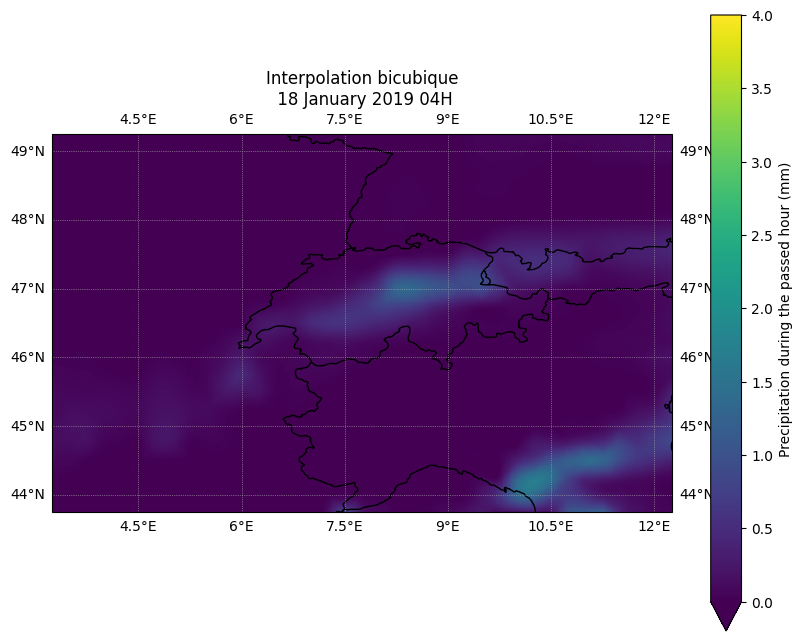

In [5]:
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Charger ton dataset ERA5
data_bicubic = precip_suisse.copy()

# Obtenir les valeurs de latitude et longitude du dataset
latitudes = data_bicubic['latitude'].values
longitudes = data_bicubic['longitude'].values
precipitation = data_bicubic['tp'].values  

# Utiliser np.linspace pour générer un nombre spécifique de points entre les bornes min et max
new_latitudes = np.linspace(latitudes.min(), latitudes.max(), 640)
new_longitudes = np.linspace(longitudes.min(), longitudes.max(), 710)

# Créer une grille de nouvelles coordonnées
new_lon, new_lat = np.meshgrid(new_longitudes, new_latitudes)

# Créer un maillage des coordonnées d'origine
lon, lat = np.meshgrid(longitudes, latitudes)

# Effectuer l'interpolation avec `griddata` de Scipy (méthode cubic pour bicubique)
precipitation_fine = griddata(
    (lon.flatten(), lat.flatten()), 
    precipitation.flatten(), 
    (new_lon, new_lat), 
    method='cubic'
)

# Créer un DataArray avec les nouvelles coordonnées
ds_interp = xr.DataArray(precipitation_fine, coords=[('latitude', new_latitudes), ('longitude', new_longitudes)])

plot_map(ds_interp, f"Images/{ref_fichier}/Interpolation bicubique.png")

# On inverse l'axe des y de la matrice (voir OneNote pourquoi)
ds_interp_iso = np.array(ds_interp)[::-1, :]

## Implémentation de l'algorithme du plus proche voisin et visualisation du résultat (résolution = 1km)

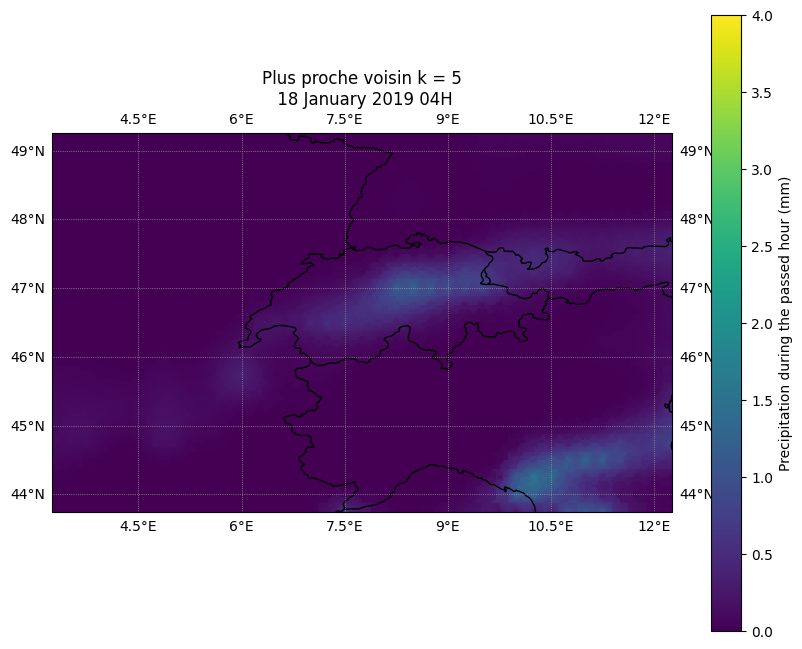

In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

# Charger ton dataset ERA5
data_bicubic = precip_suisse.copy()

# Obtenir les valeurs de latitude et longitude du dataset
latitudes = data_bicubic['latitude'].values
longitudes = data_bicubic['longitude'].values
precipitation = data_bicubic['tp'].values  

# Utiliser np.linspace pour générer un nombre spécifique de points entre les bornes min et max
new_latitudes = np.linspace(latitudes.min(), latitudes.max(), 640)
new_longitudes = np.linspace(longitudes.min(), longitudes.max(), 710)

# Créer une grille de nouvelles coordonnées
new_lon, new_lat = np.meshgrid(new_longitudes, new_latitudes)

# Créer un maillage des coordonnées d'origine
lon, lat = np.meshgrid(longitudes, latitudes)

# Aplatir les matrices pour utiliser dans le modèle KNeighborsRegressor
coords = np.vstack([lat.flatten(), lon.flatten()]).T
new_coords = np.vstack([new_lat.flatten(), new_lon.flatten()]).T

# Créer et entraîner un modèle KNeighborsRegressor
n_voisin = 5
knn = KNeighborsRegressor(n_neighbors=n_voisin, weights="distance")  # Utilisation d'un seul voisin (pour "nearest neighbor")
knn.fit(coords, precipitation.flatten())

# Faire les prédictions pour la grille fine
precipitation_fine = knn.predict(new_coords).reshape(new_latitudes.shape[0], new_longitudes.shape[0])

# Créer un DataArray avec les nouvelles coordonnées
ds_knn = xr.DataArray(precipitation_fine, coords=[('latitude', new_latitudes), ('longitude', new_longitudes)])

plot_map(ds_knn, f"Images/{ref_fichier}/Plus proche voisin k = {n_voisin}.png")
ds_knn_iso = np.array(ds_knn)[::-1, :]

## Import des données CPC 

Les données sont dans une matrice 710*640. Chaque item représente les précipitations sur un carré de 1km par 1km. La zone couverte par la matrice est donc de 640km sur 710km et couvre les latitudes : 43.6201 - 49.3767 et longitudes : 2.6896 - 12.4634 (qui correspondent un gros rectangle qui contient notamment la Suisse)

Pour lire les métadonnées

In [7]:
import h5py

# Ouvrir le fichier h5
with h5py.File(cpc_file, 'r') as file:
    # Fonction récursive pour lister les attributs de chaque groupe/dataset
    def list_attributes(name, obj):
        if isinstance(obj, h5py.Group):  # Si c'est un groupe
            print(f"Groupe: {name}")
        elif isinstance(obj, h5py.Dataset):  # Si c'est un dataset
            print(f"Dataset: {name}")
        
        # Lister les attributs
        for attr_name, attr_value in obj.attrs.items():
            print(f"  - Attribut: {attr_name} -> {attr_value}")

    # Parcours du fichier h5
    file.visititems(list_attributes)

    df = file["/dataset1/data1/data"][:]



Groupe: dataset1
Groupe: dataset1/data1
Dataset: dataset1/data1/data
  - Attribut: CLASS -> b'IMAGE'
  - Attribut: IMAGE_VERSION -> b'1.2'
  - Attribut: rhdf5-NA.OK -> [1]
Groupe: dataset1/data1/what
  - Attribut: gain -> 1.0
  - Attribut: nodata -> nan
  - Attribut: offset -> 0.0
  - Attribut: quantity -> b'ACRR'
  - Attribut: undetect -> inf
Groupe: dataset1/what
  - Attribut: enddate -> b'20190118'
  - Attribut: endtime -> b'040000'
  - Attribut: prodname -> b'CHCPC_00060'
  - Attribut: product -> b'RR'
  - Attribut: startdate -> b'20190118'
  - Attribut: starttime -> b'030000'
Groupe: how
  - Attribut: nodes -> b'WMOID:06661,WMOID:06699,WMOID:06768,WMOID:06726,WMOID:06776'
Groupe: how/MeteoSwiss
  - Attribut: Diff -> 0.582390334527884
  - Attribut: Excluded.raingauges -> b'DOL,GSB,SAE'
  - Attribut: Nr.raingauges.used -> 261
  - Attribut: PID -> b'CPC190180400'
  - Attribut: Qc -> 9.0
  - Attribut: Qr -> 9.0
  - Attribut: Qw -> 31
  - Attribut: VERSION -> b'"COMBIPRECIP-V3.9.2_2023

La fonction qui suit fait le lien entre une date et le nombre de jour écoulé depuis le début de l'année selon les standards de Météo Suisse

In [8]:
from datetime import datetime

def jours_depuis_debut_annee(date):
    # Convertir la date en objet datetime si elle n'est pas déjà dans ce format
    if isinstance(date, str):
        # Si la date est une chaîne de caractères, la convertir en datetime
        date = datetime.strptime(date, "%Y-%m-%d")  # Format : "YYYY-MM-DD"
    
    # Obtenir la date du début de l'année
    debut_annee = datetime(date.year, 1, 1)
    
    # Calculer la différence en jours
    delta = date - debut_annee
    
    return delta.days + 1

# Exemple d'utilisation :
date_input = "2024-04-15"  # Format : "YYYY-MM-DD"
nombre_de_jours = jours_depuis_debut_annee(date_input)
print(f"Nombre de jours depuis le début de l'année : {nombre_de_jours}")

Nombre de jours depuis le début de l'année : 106


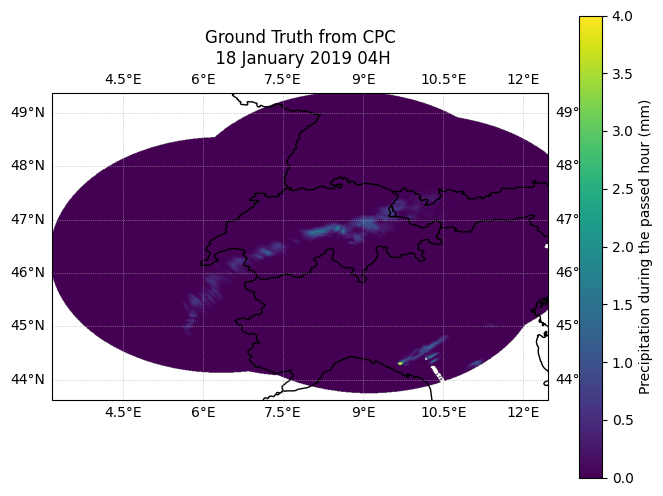

In [9]:
import h5py
import pyproj
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


# Ouvre le fichier HDF5 en mode lecture
with h5py.File(cpc_file, 'r') as f:
    # Affiche la structure du fichier

    df = f["/dataset1"]["data1"]["data"]
    df = pd.DataFrame(df[:])  

    # Définir les systèmes de coordonnées
    epsg_2056 = pyproj.CRS("EPSG:2056")
    epsg_4326 = pyproj.CRS("EPSG:4326")

    # Créer un transformateur entre les deux systèmes de coordonnées
    transformer = pyproj.Transformer.from_crs(epsg_2056, epsg_4326, always_xy=True)

    # Coordonnées des coins inférieur gauche (lower left) et supérieur droit (upper right) en EPSG:2056
    lower_left_x, lower_left_y = 2255000, 840000  # Remplacez par vos propres coordonnées
    upper_right_x, upper_right_y = 2965000, 1480000  # Remplacez par vos propres coordonnées

    # Convertir ces coordonnées en EPSG:4326 (longitude, latitude)
    lower_left_lon, lower_left_lat = transformer.transform(lower_left_x, lower_left_y)
    upper_right_lon, upper_right_lat = transformer.transform(upper_right_x, upper_right_y)


    # 📌 Création de la figure
    fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': ccrs.PlateCarree()})  # Projection EPSG:2056

    # 📌 Affichage de la heatmap
    im = ax.imshow(df, extent=[lower_left_lon, upper_right_lon, lower_left_lat, upper_right_lat], origin='upper', cmap='viridis',
                   vmin=vmin, vmax=vmax)
    #ax.set_xlim(lon_min, lon_max)  # Nouvelles limites de longitude
    #ax.set_ylim(lat_min, lat_max)

    # 📌 Ajout d'une barre de couleur
    plt.colorbar(im, ax=ax, label="Precipitation during the passed hour (mm)")
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')

    ax.gridlines(draw_labels=True, linestyle = ":", linewidth = .5)

    ax.set_title("Ground Truth from CPC" + "\n" + date)

    # Affichage
    plt.savefig(f"Images/{ref_fichier}/Ground truth.png")
    plt.show()



## Calcul des métriques pour évaluer la distance entre les images (matrices in fine)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp, entropy
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import wasserstein_distance


def métrique(pred_ini, target, nom):
    with PdfPages(f"Images/{ref_fichier}/metrics {nom}.pdf") as pdf:

        target_array = np.asarray(target)

        ### Calcul du RMSE
        res = np.nanmean((pred_ini - target_array) ** 2) ** 0.5

        pdf_str = f"Root Mean Squared Error (RMSE): {str(res):.5}"


        ### Plot de la différence (au carré) des deux matrices
        diff_matrix = (pred_ini - target_array) 

        fig, ax = plt.subplots(figsize=(8, 10), subplot_kw={"projection": ccrs.PlateCarree()})

        # Ajout de la carte (côtes, frontières, etc.)
        ax.set_extent([lon_min_output, lon_max_output, lat_min_output, lat_max_output])
        ax.add_feature(cfeature.COASTLINE, linewidth=1)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle="dotted")

        # === 3. Affichage de la heatmap ===
        # On utilise imshow() avec l'étendue correcte des lat/lon
        img = ax.imshow(diff_matrix, extent=[lon_min_output, lon_max_output, lat_min_output, lat_max_output],
                        origin="upper", cmap="viridis", alpha=0.6)  # alpha pour transparence

        # === 4. Ajout d'une barre de couleur et finalisation ===
        plt.colorbar(img, orientation="vertical", label="Difference")
        ax.set_xticks([])
        ax.set_yticks([])
        plt.title(f"{nom} - target \n" + date)

        pdf.savefig()
        plt.close()


        ### Quantile plot
        # Aplatir les matrices
        pred = pred_ini.flatten()
        target_flat = target_array.flatten()

        nb_quantiles = 1000

        deciles1 = np.percentile(pred, np.linspace(1, 100, nb_quantiles))  # Déciles pour data1
        deciles2 = np.nanpercentile(target_flat, np.linspace(1, 100, nb_quantiles))  # Déciles pour data2

        # Créer un scatter plot pour comparer les déciles
        plt.figure(figsize=(8, 8))

        # Tracer les déciles de data1 contre les déciles de data2
        plt.scatter(deciles1, deciles2, color='b', label=f'Quantiles de {nom} vs target')

        # Ajouter des labels et une légende
        plt.xlabel(f'Quantiles de {nom}')
        plt.ylabel('Quantiles de Target')
        plt.title(f'QQ plot {nom} vs target')

        # Ajouter une ligne de référence à 45° pour montrer l'égalité des déciles
        plt.plot([min(deciles1), max(deciles1)], [min(deciles1), max(deciles1)], linestyle='--', color='black', label='Reference line')

        # Afficher la légende
        plt.legend()

        # Afficher le graphique
        plt.grid(True)
        pdf.savefig()
        plt.close()

        ######## Calcul de la statistique de Kolmogorov-Smirnov pour comparer les 2 distributions
        from scipy.stats import ks_2samp

        # Calcul de la distance KS entre data1 et data2
        statistic, p_value = ks_2samp(pred[~np.isnan(pred)], target_flat[~np.isnan(target_flat)])
        pdf_str += f"\nDistance Kolmogorov-Smirnov (KS): {str(statistic):.4}, p-value: {str(p_value):.4}"


        ######## Tracé de l'estimation de la densité de probabilité
        plt.figure(figsize=(10, 8))

        # Histograms pour les deux matrices
        plt.hist(pred, bins=200, density=True, label=f'{nom}', color='blue', histtype="step")
        plt.hist(target_flat, bins=200, density=True, label='Target', color='black', histtype="step")

        # Ajouter des labels et un titre
        plt.xlabel('Precipitation')
        plt.ylabel('Density')
        plt.yscale("log")
        plt.title(f'Approached distribution {nom} VS Target')
        plt.legend()

        # Afficher le graphique
        pdf.savefig()
        plt.close()


        ###### Calcul de l'erreur sur le 99.999 ème pourcentile
        p_true = np.nanpercentile(target_flat, 99.999)  # Percentile des vraies valeurs
        p_pred = np.nanpercentile(pred, 99.999)  # Percentile des prédictions
        error_99 = abs(p_true - p_pred)
        pdf_str += f"\n99.999th Percentile Error (PE) : {str(error_99):.4} mm"


        ##### Calculer la Earth-Mover Distance (Wasserstein Distance)
        emd = wasserstein_distance(pred[~np.isnan(pred)], target_flat[~np.isnan(target_flat)])

        pdf_str += f"\nEarth-Mover Distance (EMD) : {emd:.4}"

        ##### Calcul de la Spatial-Autocorrelation Error (SAE)

        from libpysal.weights import W
        from pysal.explore import esda

        # 1. Calcul des résidus (erreurs) en excluant les NaN dans la matrice de prédiction
        residuals = target_array - pred_ini

        # On remplit résidus de 0 pour les NaN, comme ça ça n'influence pas le calcul du I de Moran
        residuals = np.nan_to_num(residuals, 0)

        # 2. Création d'une matrice de voisins pour une grille 3x3
        # Dans ce cas, nous allons créer les relations de voisinage avec la topologie "Queen" 
        # qui connecte chaque cellule à ses voisins immédiats (horizontalement, verticalement et diagonalement)
        rows, cols = pred_ini.shape


        # Dictionnaires pour les voisins et les poids
        neighbors = {}
        weights = {}

        # Remplir les dictionnaires avec les voisins et les poids
        for i in range(rows):
            for j in range(cols):
                current_cell = i * cols + j  # Indice linéaire pour la cellule (i, j)
                
                # Initialiser la liste des voisins et le dictionnaire des poids
                neighbors[current_cell] = []
                weights[current_cell] = []

                # Vérifier les voisins (haut, bas, gauche, droite)
                for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < rows and 0 <= nj < cols:  # Vérifier si le voisin est dans la matrice
                        neighbor_cell = ni * cols + nj  # Indice linéaire pour le voisin
                        neighbors[current_cell].append(neighbor_cell)  # Ajouter le voisin
                        weights[current_cell].append(1)  # Poids de 1 pour chaque voisin

        # 3. Créer un objet de poids spatiaux W à partir des dictionnaires de voisins et de poids
        w = W(neighbors, weights)



        # 4. Calcul du coefficient de Moran sur les résidus
        moran = esda.Moran(residuals, w)




        pdf_str += f"\nSpatial Auto-Correlation Error (SAE): {str(moran.I):.4}"


        # Écrire sur le pdf
        plt.figure(figsize=(8, 8))  # Format A4 en pouces

        plt.text(0, 0.5,  pdf_str, fontsize=12, verticalalignment="center", family="monospace", horizontalalignment='left')

        plt.axis("off")
        pdf.savefig()
        plt.close()

    

métrique(ds_interp_iso, df, "Interpolation bicubique")
métrique(ds_knn_iso, df, "kNN")

c:\Users\Max UNIL\AppData\Local\Programs\Python\Python312\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\Users\Max UNIL\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Le code suivant lance la pipeline des analyses jusqu'au calcul des fonctions de perte pour tous les timestamps disponibles

In [ ]:
import subprocess
import pickle

# Définir une liste de valeurs que tu veux passer à ton script
tous_les_cpc =  os.listdir("CPC_file/")

def temps_a_partir_cpc(cpc): # Extrait la date et l'heure à partir du nom du fichier
    chemin_entier = "CPC_file/" + str(cpc)
    ref_fichier = chemin_entier[9:22]
    échantillon_temps = 24*(int(ref_fichier[6:8]) - 1)+ int(ref_fichier[8:10])
    return échantillon_temps

indices_ligne = [temps_a_partir_cpc(cpc) for cpc in tous_les_cpc]

# Fichier NetCDF
netcdf_file = 'df_temp.nc'

# Boucle pour exécuter le script avec différentes valeurs et lignes spécifiques
for cpc, ligne_index in zip(tous_les_cpc, indices_ligne):
    print(cpc)
    # Extraire la ligne du fichier NetCDF
    ligne = ds.isel(time = ligne_index)
    # Sauvegarder la ligne extraite dans un fichier pickle temporaire
    pickle_file = f'ligne_{ligne_index}.pkl'
    with open(pickle_file, 'wb') as f:
        pickle.dump(ligne, f)
    
    # Appeler le script_a_executer.py avec la valeur et la ligne extraite
    result = subprocess.run(['python', 'automatisation_all_timestamps.py', "CPC_file/" + str(cpc), pickle_file], capture_output=True, text=True)
    print(result.stdout)
    # print(result.stderr)

    # Supprimer le fichier pickle après utilisation
    os.remove(pickle_file)

CPC1901120009_00060.801.h5

c:\Users\Max UNIL\AppData\Local\Programs\Python\Python312\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)

CPC1901408009_00060.801.h5

c:\Users\Max UNIL\AppData\Local\Programs\Python\Python312\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network i

Test CNN

In [25]:
from keras import models, layers
from keras.datasets import mnist
from keras.utils import to_categorical

class CNN():
    def __init__(self, num_classes):
        self.model = self.build_model() 
        self.num_classes = num_classes

    def build_model(self):
        model = models.Sequential()

        # Couche 1 
        model.add(layers.Conv2D(2, (3, 3), activation = "relu"))
        model.add(layers.MaxPool2D((2, 2)))


        # MLP
        model.add(layers.Flatten())
        model.add(layers.Dense(10, activation = "softmax"))

        return model
    
model = CNN(10).build_model()

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

# Normaliser les données
train_data = train_data.reshape((train_data.shape[0], 28, 28, 1)).astype('float32') / 255
test_data = test_data.reshape((test_data.shape[0], 28, 28, 1)).astype('float32') / 255

# Convertir les labels en format one-hot
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

model.fit(train_data, train_labels, batch_size=40, epochs=1, validation_data=(test_data, test_labels))




1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7402 - loss: 0.8902 - val_accuracy: 0.9070 - val_loss: 0.3150


In [26]:
predictions = model.predict(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step


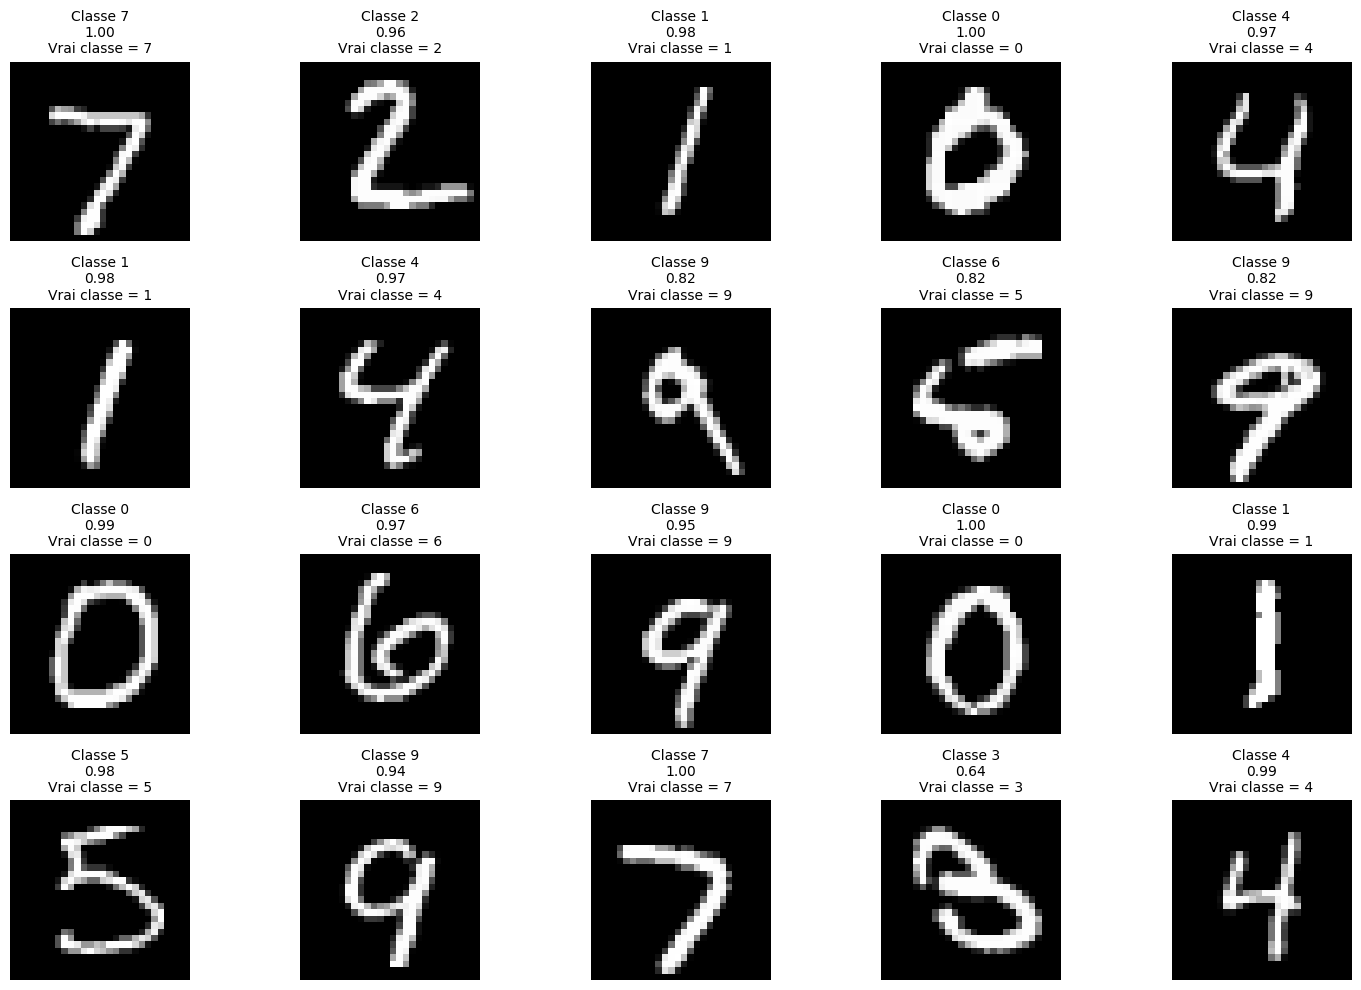

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Afficher un certain nombre d'images avec leurs prédictions
num_images_to_show = 20  # Nombre d'images à afficher
class_names = [f"Classe {k}" for k in range(10)]  # Liste des classes

# Créer un plot pour afficher plusieurs images
images_per_row = 5  # Nombre d'images par ligne
num_rows = (num_images_to_show // images_per_row) + (num_images_to_show % images_per_row > 0)  # Calcul du nombre de lignes

fig, axes = plt.subplots(num_rows, images_per_row, figsize=(15, 10))

# Aplatir le tableau d'axes pour faciliter l'indexation
axes = axes.ravel()

# Afficher les images
for i in range(num_images_to_show):
    ax = axes[i]
    ax.imshow(test_data[i], cmap='gray')  # Si l'image est en nuances de gris
    ax.axis('off')

    # Obtenir la prédiction softmax
    pred = predictions[i]
    predicted_class = np.argmax(pred)  # Classe prédite
    pred_prob = pred[predicted_class]  # Probabilité de la classe prédite

    # Afficher le titre avec la classe prédite et la probabilité
    ax.set_title(f"{class_names[predicted_class]}\n{pred_prob:.2f}\nVrai classe = {np.argmax(test_labels[i])}", fontsize=10)

# Ajuster l'espace entre les images
plt.tight_layout()
plt.show()
